# RA2CE feature: Isolated locations

This notebook contains an example of the **isolated locations analysis** of the RA2CE model. This analysis can be used to assess whether locations can still reach the main part of a network during a disruption. RA2CE specifies the reason of isolation: whether the location is isolated because of link disruption close to the location or because of link disruptions in other locations further away. For example, a residential home could be disrupted in using the road network because of high water on the road right in front of the house or because they cannot leave their neighbourhood because of road flooding.

First of all, we will import the packages we need to execute the notebook:

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ra2ce.ra2ce_handler import Ra2ceHandler #import the ra2cehandler to run ra2ce analyses
import rasterio
import shutil

c:\Users\meije_le\Anaconda3\envs\ra2ce_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we will set the path to the RA2CE example folder and we will check if the network and analysis ini files indeed exist. We remove any files that might already be inside the output folders.

In [2]:
root_dir = Path("data","isolated_locations")  # set the root directory for the data

network_ini = root_dir / "network.ini"
assert network_ini.is_file()

analyses_ini = root_dir / "analyses.ini"
assert analyses_ini.is_file()

output_path = root_dir / "output"
output_graph_path = root_dir / "static" / "output_graph"

for p in [output_path, output_graph_path]:
    if p.exists():
        shutil.rmtree(p)

## Configuring the network
Firstly we initialize RA2CE and configure the network with the *network.ini* and *analyses.ini* files. See below the contents of the *network.ini* file and pay special attention to the configurations in **bold**. These are filled in especially for this isolated locations analysis.

**Network.ini content**
<br>
<br>
> [project]<br>
name = isolated_locations<br>
<br>
[network]<br>
directed = False<br>
**source = OSM download**<br>
primary_file = None<br>
diversion_file = None<br>
file_id = None<br>
**polygon = map.geojson**<br>
**network_type = drive**<br>
**road_types = motorway,motorway_link,trunk,trunk_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link**<br>
save_gpkg = True<br>
<br>
[origins_destinations]<br>
origins = None<br>
destinations = None<br>
origins_names = None<br>
destinations_names = None<br>
id_name_origin_destination = None<br>
origin_count = None<br>
origin_out_fraction = None<br>
category = None<br>
<br>
[isolation]<br>
**locations = POI.gpkg**<br>
<br>
[hazard]<br>
**hazard_map = max_flood_depth.tif**<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
**aggregate_wl = max**<br>
**hazard_crs = EPSG:32736**<br>
<br>
*[cleanup]  # Can only be used if a network is created from a shapefile<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = False<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*

As you can see in the *network.ini* file above, we submit a hazard map in the configuration file: *max_flood_depth.tif*. We will inspect this hazard map below.

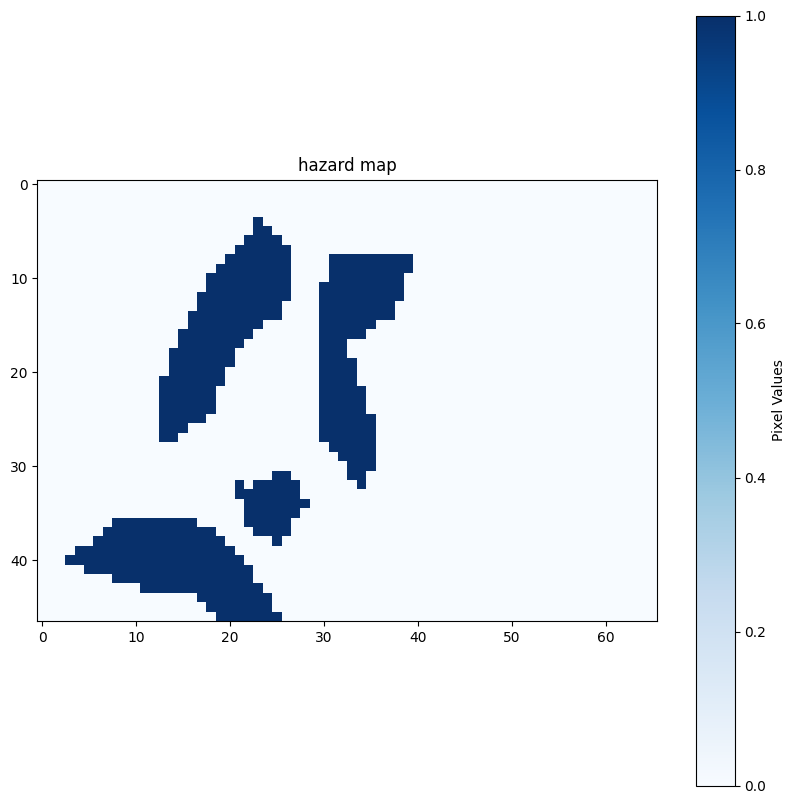

In [3]:
hazard_folder = root_dir / "static" / "hazard" # find the hazard folder where you locate your hazard map
hazard_map = hazard_folder / "fake_flood.tif" # set the name of the hazard map

# Open the TIF file using rasterio
with rasterio.open(hazard_map) as src:
    # Read the TIF file as a numpy array
    tif_array = src.read(1)  # Change the band index (1) if necessary

plt.figure(figsize=(10, 10))
plt.imshow(tif_array, cmap='Blues', vmin=0, vmax=1)  # Change the colormap if desired
plt.colorbar(label='Pixel Values')
plt.title('hazard map')
plt.show()  

Including, amongst others, this hazard map we initialize RA2CE and configure the network. This takes around 2 minutes, depending on internet and computer speed.

In [4]:
handler = Ra2ceHandler(network=network_ini, analysis=analyses_ini)
handler.configure()

2023-11-23 10:40:23 AM - [ra2ce_logging.py:41] - root - INFO - RA2CE logger initialized.
2023-11-23 10:40:23 AM - [network_config_wrapper.py:82] - root - ERROR - Graph dir not found. Value provided: data\isolated_locations\static\output_graph
2023-11-23 10:40:23 AM - [network_wrapper_factory.py:53] - root - INFO - Start creating a network from the submitted shapefile.
2023-11-23 10:40:23 AM - [osm_network_wrapper.py:56] - root - INFO - Start downloading a network from OSM.
2023-11-23 10:40:24 AM - [osm_network_wrapper.py:176] - root - INFO - graph downloaded from OSM with 6,193 nodes and 6,814 edges
c:\Users\meije_le\Anaconda3\envs\ra2ce_env\lib\site-packages\osmnx\simplification.py:462: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
c:\Users\meije_le\Anacond

The resulting network (edges and nodes) including hazard overlay is shown in the map below, bounded by the region of interest (*map.geojson*) that was submitted in the *network.ini* file.

In [5]:
# REGION
region = root_dir / "static" / "network" / "map.geojson"
region = gpd.read_file(region)
m = region.explore(style_kwds={"color": "purple", "fill": False, "weight": 5})

# EDGES
edges_with_hazard = root_dir / "static" / "output_graph" / "base_graph_hazard_edges.gpkg"
edges = gpd.read_file(edges_with_hazard)
edges.explore(m=m, column="EV1_ma", cmap="brg_r", style_kwds={"weight": 3})

# LOCATIONS TO CHECK ISOLATION
locations_path = root_dir / "static" / "network" / "POI.gpkg"
locations = gpd.read_file(locations_path)
locations.explore(m=m, column="building")


## Running the analysis
Next, we run the isolated location analysis with ra2ce, which is already configured with the following *analyses.ini* file. See below the contents of this file.

**Analyses.ini content**
<br>
<br>
> [project]<br>
name = isolated_locations<br>
<br>
[analysis1]<br>
name = multilink isolated locations<br>
analysis = multi_link_isolated_locations<br>
aggregate_wl = max<br>
threshold = 1<br>
weighing = length<br>
category_field_name = category<br>
save_gpkg = True<br>
save_csv = True<br>

In [6]:
handler.run_analysis()

2023-11-23 10:42:17 AM - [analyses_indirect.py:1027] - root - INFO - ----------------------------- Started analyzing 'multi link isolated locations'  -----------------------------
2023-11-23 10:42:18 AM - [analyses_indirect.py:1328] - root - INFO - Results saved to: data\isolated_locations\output\multi_link_isolated_locations\multi_link_isolated_locations.gpkg
2023-11-23 10:42:18 AM - [analyses_indirect.py:1304] - root - INFO - ----------------------------- Analysis 'multi link isolated locations' finished. Time: 1.02s  -----------------------------


## Inspect results

In [7]:
## ROADS
m = edges.explore(column="EV1_ma", cmap="brg_r", style_kwds={"weight": 3})

## ISOLATED LOCATIONS
locations_results_path = root_dir / "output" / "multi_link_isolated_locations" / "multi_link_isolated_locations.gpkg"
locations_results = gpd.read_file(locations_results_path)
locations_results.explore(m=m, column="i_type_EV1", cmap="gist_rainbow")
m

We also check the summarized results. As you can see in the table below, most locations are isolated due to flooding. Some are isolated due to road disruptions in another part of the network.

In [8]:
tabulated_results_path = root_dir / "output" / "multi_link_isolated_locations" / "multi_link_isolated_locations_results.csv"
tabulated_results = pd.read_csv(tabulated_results_path)
tabulated_results.sort_values("i_type_EV1")

building i_type_EV1  nr_isolated hazard
0  apartments    flooded          385    EV1
2  commercial    flooded            3    EV1
3      garage    flooded            4    EV1
4       house    flooded          340    EV1
6  industrial    flooded            8    EV1
8         yes    flooded            2    EV1
1  apartments   isolated           87    EV1
5       house   isolated            3    EV1
7  industrial   isolated            6    EV1